In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Hsuweic/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Load the data

In [4]:
dataset = pd.read_csv('./dataset/cleaned_dataset.csv')
print(dataset.shape)
print(dataset.head(10))
print(dataset.describe())

(20620, 2)
   label                                              tweet
0      1   rt  boy dats coldtyga dwn bad for cuffin dat ...
1      1   rt  dawg rt  you ever fuck a bitch and she st...
2      1          rt ganderson based she look like a tranny
3      1   rt  the shit you hear about me might be true ...
4      1  madisonx the shit just blows meclaim you so fa...
5      1  brighterdays i can not just sit up and hate on...
6      1  8220 cause im tired of you big bitches coming ...
7      1   amp you might not get ya bitch back amp thats...
8      1               hobbies include fighting mariambitch
9      1   keeks is a bitch she curves everyone  lol i w...
              label
count  20620.000000
mean       0.930650
std        0.254055
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000


In [5]:
from sklearn.model_selection import train_test_split

X = dataset['tweet']  # Input features
y = dataset['label']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Training set shape: ", X_train.shape, "\nLabel distribution: \n", y_train.value_counts())
print("\nTesting set shape: ", X_test.shape, "\nLabel distribution: \n", y_test.value_counts())

Training set shape:  (15465,) 
Label distribution: 
 label
1    14358
0     1107
Name: count, dtype: int64

Testing set shape:  (5155,) 
Label distribution: 
 label
1    4832
0     323
Name: count, dtype: int64


### Feature engineering and imbalanced data handling

In [6]:
from nltk.tokenize import TweetTokenizer, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

# Define sampling methods
sampling_methods = {
    'SMOTE': SMOTE(),
    'ENN': EditedNearestNeighbours(),
    'SMOTEENN': SMOTEENN()
}

# Define vectorizers
vectorizers = {
    'TfidfVectorizer_Tweet': TfidfVectorizer(tokenizer=TweetTokenizer().tokenize),
    'TfidfVectorizer_Word': TfidfVectorizer(tokenizer=word_tokenize)
}

# Define models
models = {
    'LogisticRegression': LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Construct pipelines for each combination of sampling methods, vectorizers, and models
pipelines = []
for sampling_method_name, sampling_method in sampling_methods.items():
    for vectorizer_name, vectorizer in vectorizers.items():
        for model_name, model in models.items():
            steps = [('vectorizer', vectorizer),
                     ('sampling', sampling_method),
                     ('clf', model)]
            pipeline_name = f"{sampling_method_name}_{vectorizer_name}_{model_name}"
            pipeline = ImbPipeline(steps)
            pipelines.append((pipeline_name, pipeline))


### Model Training & Evaluation

Training SMOTE_TfidfVectorizer_Tweet_LogisticRegression...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Evaluation results for SMOTE_TfidfVectorizer_Tweet_LogisticRegression:
                    precision    recall  f1-score   support

       Hate Speech       0.32      0.59      0.42       323
Offensive Language       0.97      0.92      0.94      4832

          accuracy                           0.90      5155
         macro avg       0.65      0.76      0.68      5155
      weighted avg       0.93      0.90      0.91      5155



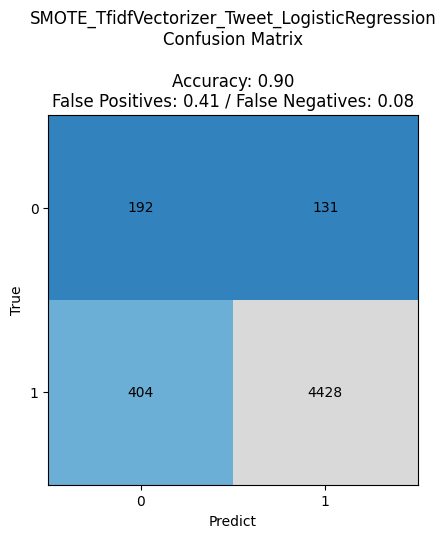

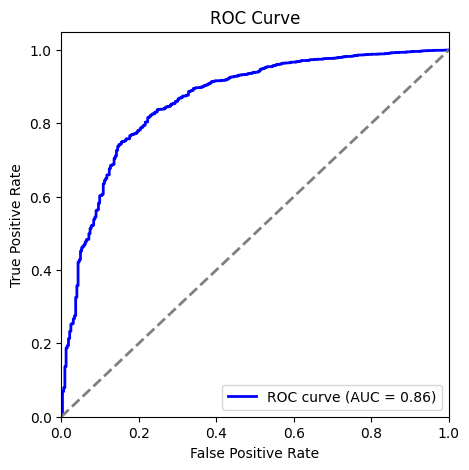

Training SMOTE_TfidfVectorizer_Tweet_RandomForest...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Evaluation results for SMOTE_TfidfVectorizer_Tweet_RandomForest:
                    precision    recall  f1-score   support

       Hate Speech       0.45      0.18      0.25       323
Offensive Language       0.95      0.99      0.97      4832

          accuracy                           0.93      5155
         macro avg       0.70      0.58      0.61      5155
      weighted avg       0.92      0.93      0.92      5155



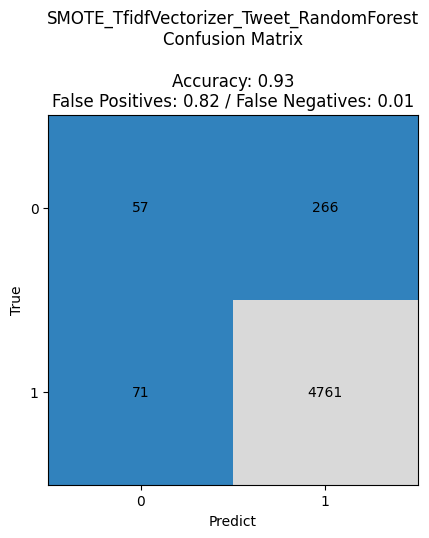

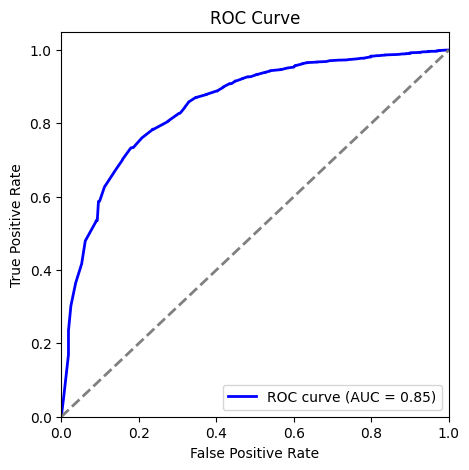

Training SMOTE_TfidfVectorizer_Word_LogisticRegression...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Evaluation results for SMOTE_TfidfVectorizer_Word_LogisticRegression:
                    precision    recall  f1-score   support

       Hate Speech       0.31      0.58      0.40       323
Offensive Language       0.97      0.91      0.94      4832

          accuracy                           0.89      5155
         macro avg       0.64      0.74      0.67      5155
      weighted avg       0.93      0.89      0.91      5155



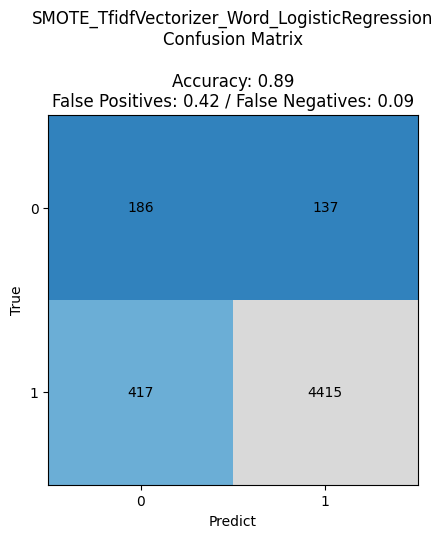

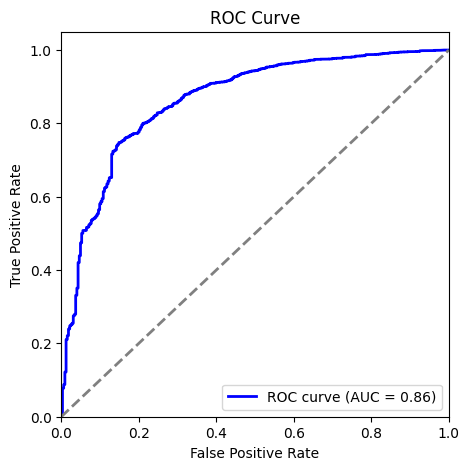

Training SMOTE_TfidfVectorizer_Word_RandomForest...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Evaluation results for SMOTE_TfidfVectorizer_Word_RandomForest:
                    precision    recall  f1-score   support

       Hate Speech       0.43      0.15      0.22       323
Offensive Language       0.95      0.99      0.97      4832

          accuracy                           0.93      5155
         macro avg       0.69      0.57      0.59      5155
      weighted avg       0.91      0.93      0.92      5155



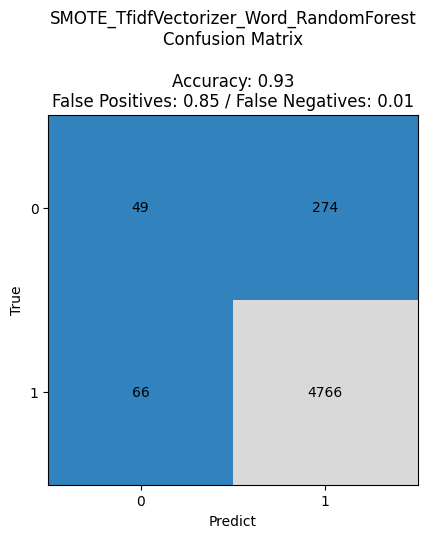

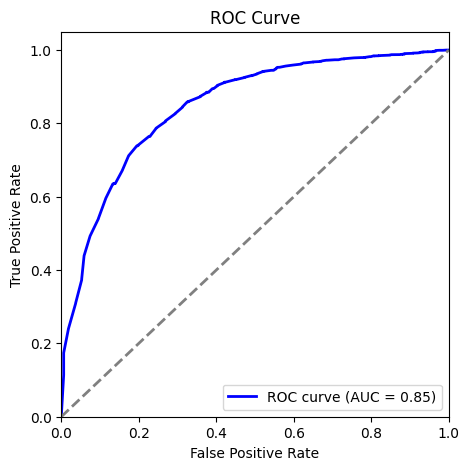

Training ENN_TfidfVectorizer_Tweet_LogisticRegression...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Evaluation results for ENN_TfidfVectorizer_Tweet_LogisticRegression:
                    precision    recall  f1-score   support

       Hate Speech       0.49      0.23      0.31       323
Offensive Language       0.95      0.98      0.97      4832

          accuracy                           0.94      5155
         macro avg       0.72      0.61      0.64      5155
      weighted avg       0.92      0.94      0.93      5155



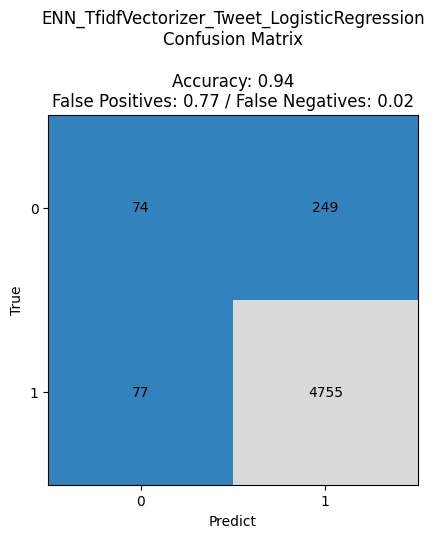

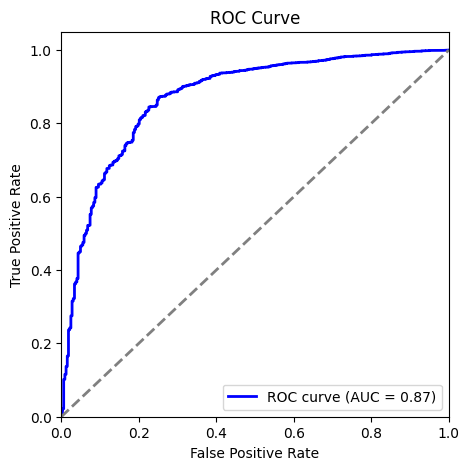

Training ENN_TfidfVectorizer_Tweet_RandomForest...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Evaluation results for ENN_TfidfVectorizer_Tweet_RandomForest:
                    precision    recall  f1-score   support

       Hate Speech       0.44      0.40      0.42       323
Offensive Language       0.96      0.97      0.96      4832

          accuracy                           0.93      5155
         macro avg       0.70      0.68      0.69      5155
      weighted avg       0.93      0.93      0.93      5155



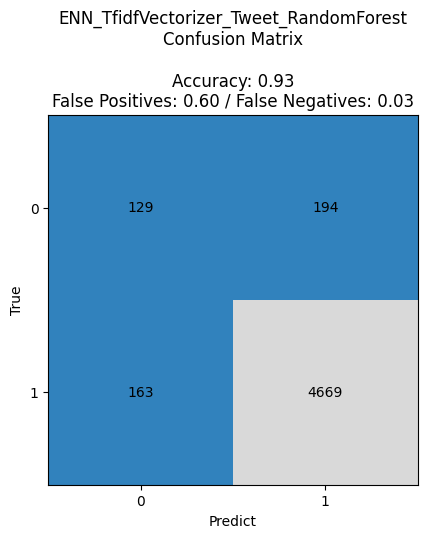

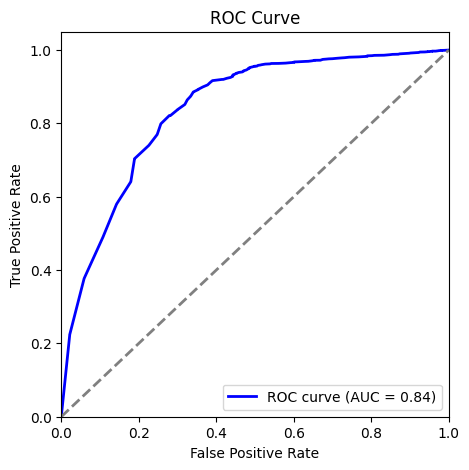

Training ENN_TfidfVectorizer_Word_LogisticRegression...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Evaluation results for ENN_TfidfVectorizer_Word_LogisticRegression:
                    precision    recall  f1-score   support

       Hate Speech       0.49      0.22      0.30       323
Offensive Language       0.95      0.98      0.97      4832

          accuracy                           0.94      5155
         macro avg       0.72      0.60      0.63      5155
      weighted avg       0.92      0.94      0.92      5155



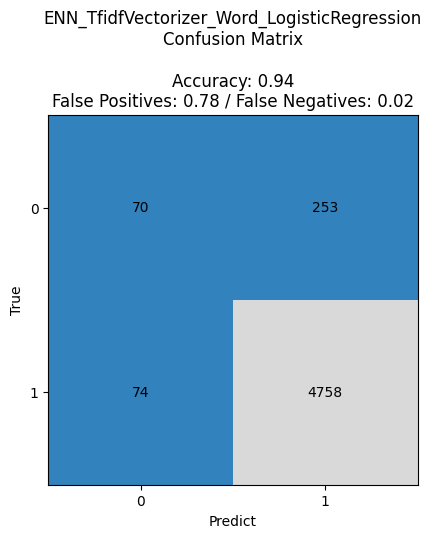

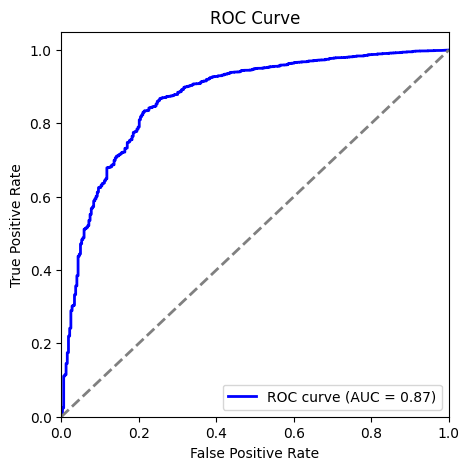

Training ENN_TfidfVectorizer_Word_RandomForest...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Evaluation results for ENN_TfidfVectorizer_Word_RandomForest:
                    precision    recall  f1-score   support

       Hate Speech       0.45      0.41      0.43       323
Offensive Language       0.96      0.97      0.96      4832

          accuracy                           0.93      5155
         macro avg       0.70      0.69      0.69      5155
      weighted avg       0.93      0.93      0.93      5155



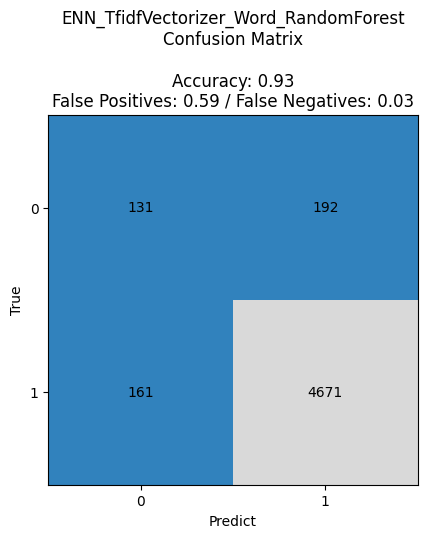

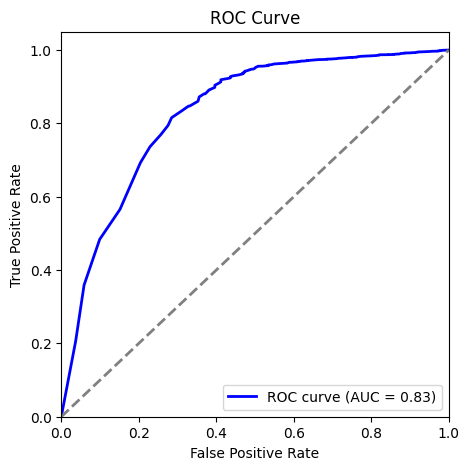

Training SMOTEENN_TfidfVectorizer_Tweet_LogisticRegression...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Evaluation results for SMOTEENN_TfidfVectorizer_Tweet_LogisticRegression:
                    precision    recall  f1-score   support

       Hate Speech       0.09      0.97      0.16       323
Offensive Language       0.99      0.35      0.52      4832

          accuracy                           0.39      5155
         macro avg       0.54      0.66      0.34      5155
      weighted avg       0.94      0.39      0.49      5155



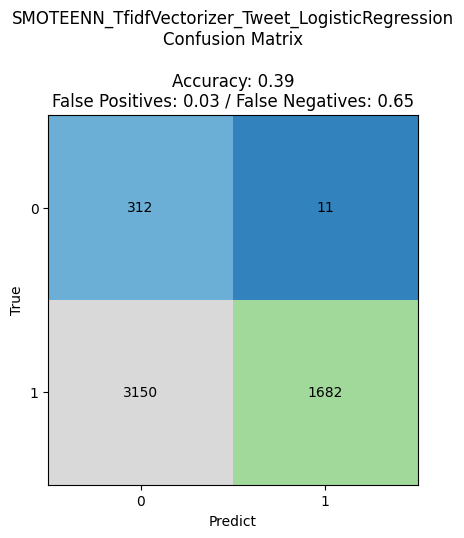

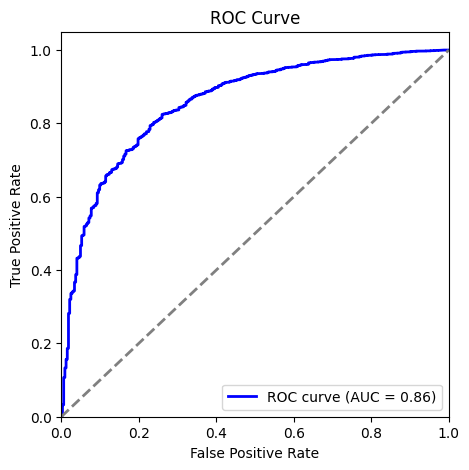

Training SMOTEENN_TfidfVectorizer_Tweet_RandomForest...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Evaluation results for SMOTEENN_TfidfVectorizer_Tweet_RandomForest:
                    precision    recall  f1-score   support

       Hate Speech       0.11      0.91      0.19       323
Offensive Language       0.99      0.49      0.65      4832

          accuracy                           0.52      5155
         macro avg       0.55      0.70      0.42      5155
      weighted avg       0.93      0.52      0.63      5155



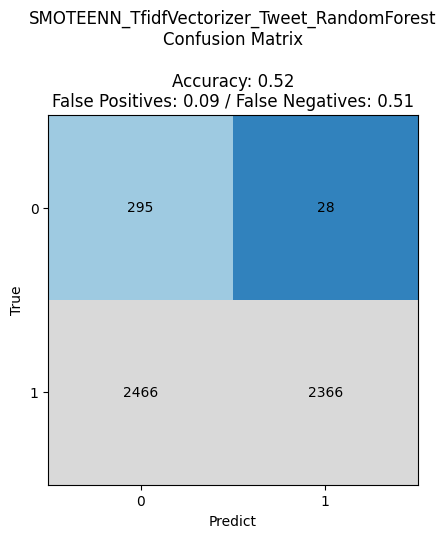

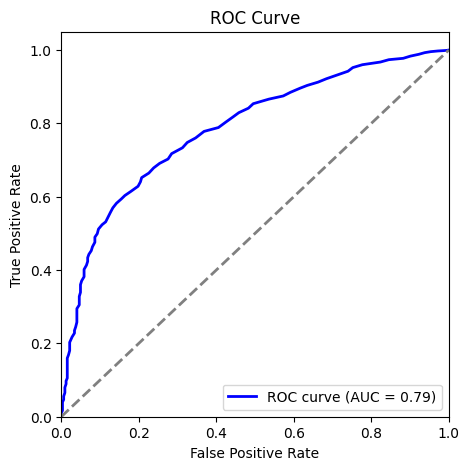

Training SMOTEENN_TfidfVectorizer_Word_LogisticRegression...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Evaluation results for SMOTEENN_TfidfVectorizer_Word_LogisticRegression:
                    precision    recall  f1-score   support

       Hate Speech       0.09      0.97      0.17       323
Offensive Language       0.99      0.35      0.52      4832

          accuracy                           0.39      5155
         macro avg       0.54      0.66      0.34      5155
      weighted avg       0.94      0.39      0.50      5155



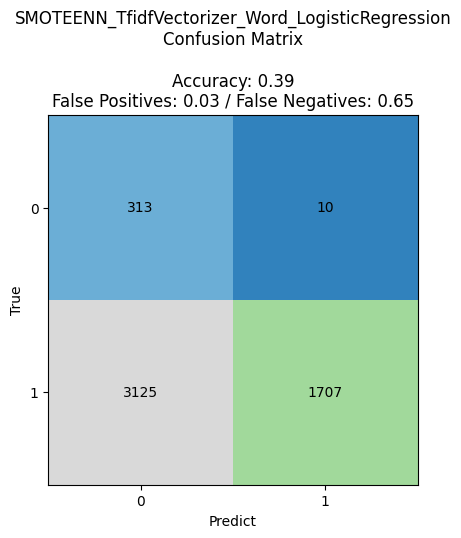

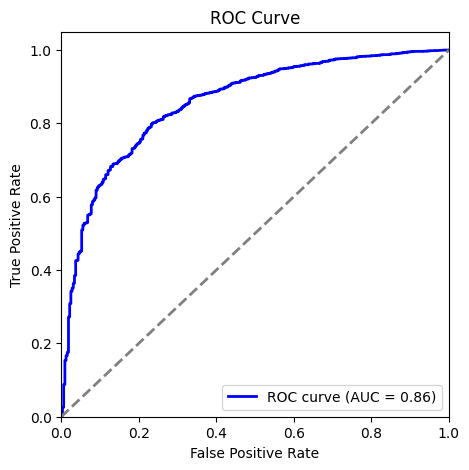

Training SMOTEENN_TfidfVectorizer_Word_RandomForest...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Evaluation results for SMOTEENN_TfidfVectorizer_Word_RandomForest:
                    precision    recall  f1-score   support

       Hate Speech       0.11      0.92      0.19       323
Offensive Language       0.99      0.48      0.65      4832

          accuracy                           0.51      5155
         macro avg       0.55      0.70      0.42      5155
      weighted avg       0.93      0.51      0.62      5155



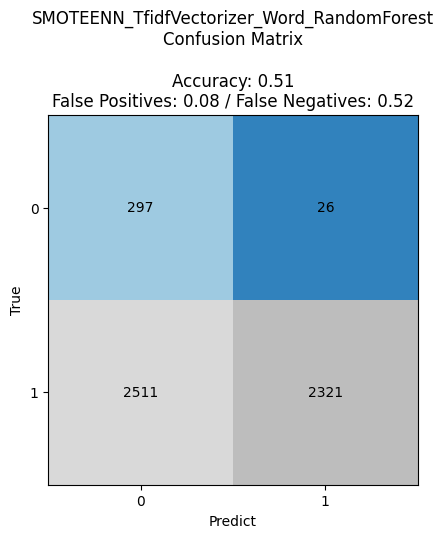

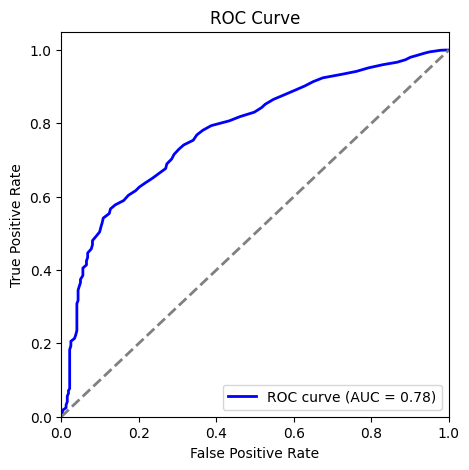

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Train and evaluate each pipeline
for pipeline_name, pipeline in pipelines:
    print(f"Training {pipeline_name}...")
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    
    # Evaluate the pipeline on the testing data
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print classification report
    print(f"Evaluation results for {pipeline_name}:")
    print(classification_report(y_test, y_pred, target_names=['Hate Speech', 'Offensive Language']))
    
    # Evaluate models by the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Extract FP, FN from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate false positives (FP) and false negatives (FN)
    false_positives = fp / (fp + tn)
    false_negatives = fn / (fn + tp)
 
    # Create a confusion matrix plot
    fig, ax = plt.subplots()

    # Plot the confusion matrix
    for (j, i), label in np.ndenumerate(cm):
        ax.text(i, j, label, ha='center', va='center')

    ax.set_title(f'{pipeline_name}\nConfusion Matrix\n\nAccuracy: {accuracy:.2f}\nFalse Positives: {false_positives:.2f} / False Negatives: {false_negatives:.2f}')
    ax.imshow(cm, cmap='tab20c')
    ax.set_xticks([1, 0])
    ax.set_yticks([1, 0])
    ax.set_xlabel('Predict')
    ax.set_ylabel('True')

    # Create a ROC-AUC curve plot with score
    y_predict_proba = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba)
    roc_auc = roc_auc_score(y_test, y_predict_proba)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


### Imbalance method comparision

Metrics: logistic regression, f1 score, hate speech

Undersampling

- ENN: Removes majority class examples that differ from their neighbors.
  - 0.42
Training set shape:  (13518, 18863)
Label distribution:
 label
1    12411
0     1107

- Tomek Links: Identifies pairs of very close instances, but of opposite classes, and removes the majority class instances from the pair.
  - 0.32
Training set shape:  (15309, 18863)
Label distribution:
 label
1    14202
0     1107

- Repeated Edited Nearest Neighbours (RENN): Iterates ENN multiple times to further edit the dataset.
  - 0.43
Training set shape:  (12956, 18863)
Label distribution:
 label
1    11849
0     1107

Oversampling

- SMOTE (Synthetic Minority Over-sampling Technique): Generates synthetic samples by interpolating between existing minority instances.
  - 0.41
Training set shape:  (28716, 18863)
Label distribution:
 label
1    14358
0    14358



Hybrid Methods

- SMOTEENN: Combines SMOTE and ENN.
  - 0.20
Training set shape:  (16433, 18863)
Label distribution:
 label
0    14198
1     2235
Name: count, dtype: int64

- SMOTETomek: Combines SMOTE and Tomek Links.
  - 0.40
Training set shape:  (28716, 18863)
Label distribution:
 label
1    14358
0    14358
Name: count, dtype: int64




